In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
!pip install tifffile

# **Import Drive**

In [3]:

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


### **Sentinel-2 Land-Cover Subet Dataset with 5 Categories, having 100 images each**

In [4]:
aerial_path = '/content/drive/MyDrive/sentinel-2_rgb'

In [5]:
import tifffile
from PIL import Image
from torchvision.transforms import ToTensor

files_0 = os.listdir(aerial_path+'/0/')
files_1 = os.listdir(aerial_path+'/1/')
files_2 = os.listdir(aerial_path+'/2/')
files_3 = os.listdir(aerial_path+'/3/')
files_4 = os.listdir(aerial_path+'/4/')



img_rgb_0  = Image.open(aerial_path + '/0/' + files_0[5])
img_rgb_1  = Image.open(aerial_path + '/1/' + files_1[15])
img_rgb_2  = Image.open(aerial_path + '/2/' + files_2[45])
img_rgb_3  = Image.open(aerial_path + '/3/' + files_3[30])
img_rgb_4  = Image.open(aerial_path + '/4/' + files_4[70])


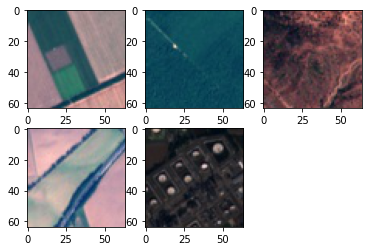

In [6]:
plt.subplot(231)
plt.imshow(img_rgb_0)
plt.subplot(232)
plt.imshow(img_rgb_1)
plt.subplot(233)
plt.imshow(img_rgb_2)
plt.subplot(234)
plt.imshow(img_rgb_3)
plt.subplot(235)
plt.imshow(img_rgb_4)


# **Path to Aerial Dataset**
(A combination of samples from Small Village and Industrial Datasets from Sensefly)

# **Aerial Dataset Class**

In [7]:
def get_sat_data(folder_path,transforms=None):
  if transforms:
    dataset_full = ImageFolder(folder_path,preprocessor)
  else:
    dataset_full = ImageFolder(folder_path,preprocessor)

  
  return dataset_full



In [8]:
'''
target = '/content/drive/MyDrive/sentinel-2_rgb/4/'
files = os.listdir(aerial_path+'/4/')
files.sort()
for file in tqdm(files):
  img_13  = tifffile.imread(aerial_path + '/4/' + file)
  img_bgr = img_13[:,:,1:4]
  #img = img_bgr[::-1]
  img = cv2.normalize(img_bgr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

  cv2.imwrite(target+file.split('.')[0]+'.jpg',img)
'''

"\ntarget = '/content/drive/MyDrive/sentinel-2_rgb/4/'\nfiles = os.listdir(aerial_path+'/4/')\nfiles.sort()\nfor file in tqdm(files):\n  img_13  = tifffile.imread(aerial_path + '/4/' + file)\n  img_bgr = img_13[:,:,1:4]\n  #img = img_bgr[::-1]\n  img = cv2.normalize(img_bgr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)\n\n  cv2.imwrite(target+file.split('.')[0]+'.jpg',img)\n"

In [9]:
'''
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP','.tif'
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


def make_dataset(dir, class_to_idx):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_image_file(fname):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    images.append(item)

    return images

class ImageFolder(torch.utils.data.Dataset):

  def __init__(self, root, transform=None, target_transform=None):
      classes, class_to_idx = find_classes(root)
      imgs = make_dataset(root, class_to_idx)
      if len(imgs) == 0:
          raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                              "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

      self.root = root
      self.imgs = imgs
      self.classes = classes
      self.class_to_idx = class_to_idx
      self.transform = transform
      self.target_transform = target_transform

  def __getitem__(self, index):

      path, target = self.imgs[index]
      #print(ok)
      #img = self.loader(path)
      img_13  = tifffile.imread(path)
      img_bgr = img_13[:,:,1:4]
      img = img_bgr[::-1]
      img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
      if self.transform is not None:
          img = self.transform(img)
      if self.target_transform is not None:
          target = self.target_transform(target)
      return img, target

  def __len__(self):
      return len(self.imgs)
'''

'\ndef find_classes(dir):\n    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]\n    classes.sort()\n    class_to_idx = {classes[i]: i for i in range(len(classes))}\n    return classes, class_to_idx\n\nIMG_EXTENSIONS = [\n    \'.jpg\', \'.JPG\', \'.jpeg\', \'.JPEG\',\n    \'.png\', \'.PNG\', \'.ppm\', \'.PPM\', \'.bmp\', \'.BMP\',\'.tif\'\n]\n\ndef is_image_file(filename):\n    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)\n\n\ndef make_dataset(dir, class_to_idx):\n    images = []\n    dir = os.path.expanduser(dir)\n    for target in sorted(os.listdir(dir)):\n        d = os.path.join(dir, target)\n        if not os.path.isdir(d):\n            continue\n\n        for root, _, fnames in sorted(os.walk(d)):\n            for fname in sorted(fnames):\n                if is_image_file(fname):\n                    path = os.path.join(root, fname)\n                    item = (path, class_to_idx[target])\n                    images.append(

# **Dataset and Dataloader initialization**

In [10]:
#Pre processing the data
normalize = transforms.Normalize(mean = [0.485,0.456,0.406],
                                std = [0.229,0.224,0.225])
resize = transforms.Resize((224,224))



preprocessor = transforms.Compose([ resize, transforms.ToTensor(), normalize
                                   ])

aerial_dataset_full = get_sat_data(aerial_path,preprocessor)

# Creating data indices for training and validation splits:
dataset_size = len(aerial_dataset_full)
indices = list(range(dataset_size))
validation_split = 0.2
split = int(np.floor(validation_split * dataset_size))
shuffle_dataset = True
random_seed= 101

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

aerial_train_loader = torch.utils.data.DataLoader(aerial_dataset_full, batch_size=16, 
                                           sampler=train_sampler)
aerial_validation_loader = torch.utils.data.DataLoader(aerial_dataset_full, batch_size=16,
                                                sampler=valid_sampler)

In [11]:
print(aerial_dataset_full[0])

(tensor([[[-1.6898, -1.6898, -1.6898,  ...,  0.3994,  0.3823,  0.3823],
         [-1.6898, -1.6898, -1.6898,  ...,  0.3994,  0.3823,  0.3823],
         [-1.6898, -1.6898, -1.6898,  ...,  0.3823,  0.3652,  0.3652],
         ...,
         [-2.0494, -2.0494, -2.0494,  ...,  1.0844,  1.1015,  1.1015],
         [-2.0494, -2.0494, -2.0494,  ...,  1.1015,  1.1187,  1.1187],
         [-2.0494, -2.0494, -2.0494,  ...,  1.1015,  1.1187,  1.1187]],

        [[-0.5651, -0.5651, -0.5651,  ..., -0.1800, -0.1975, -0.1975],
         [-0.5651, -0.5651, -0.5651,  ..., -0.1800, -0.1975, -0.1975],
         [-0.5651, -0.5651, -0.5651,  ..., -0.1975, -0.2150, -0.2150],
         ...,
         [-1.3004, -1.3004, -1.3004,  ...,  0.1702,  0.1877,  0.1877],
         [-1.2829, -1.2829, -1.2829,  ...,  0.1877,  0.2052,  0.2052],
         [-1.2829, -1.2829, -1.2829,  ...,  0.1877,  0.2052,  0.2052]],

        [[-0.6541, -0.6541, -0.6541,  ..., -0.2707, -0.2881, -0.2881],
         [-0.6541, -0.6541, -0.6541,  ..., -

In [12]:
num_classes = 5

# **Training and Validation/Test loop**

In [13]:
def training_and_validation_loop(epochs,xp_lr_scheduler,model,optmizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,saved_model_name):

  train_loss = []
  test_loss = []
  accuracy = []

  for e in range(epochs):
        step_lr_scheduler.step()
      
        #put model in training mode
        model.train()
        avg_loss = 0

        for i, (x,y) in enumerate(aerial_train_loader):
              optimizer.zero_grad()

              if gpu_flag:
                    img_var = Variable(x).cuda()
                    label_actual = Variable(y).cuda()
              else:
                    img_var = Variable(x)
                    label_actual = Variable(y)

              label_predicted = model.forward(img_var)
              loss = criterion(label_predicted,label_actual)
              loss.backward()
              
              if(i%10 == 0):
                    print(i, loss.item())
              avg_loss+=loss.item()
              optimizer.step()
              
        print("Done Training")
        train_loss.append(avg_loss*1.0/(i+1))
        
        #set model in evaluation mode
        model.eval()
        avg_loss = 0
        correct_pred = 0
        total_pred = 0
        
        for i, (x_test,y_test) in enumerate(aerial_validation_loader):

            if gpu_flag:
                img_test_var = Variable(x_test).cuda()
                label_test_var = Variable(y_test).cuda()
            else:
                img_test_var = Variable(x_test)
                label_test_var = Variable(y_test)

            label_predicted_test = model.forward(img_test_var)
            loss = criterion(label_predicted_test,label_test_var)
            avg_loss+=loss.item()
            vals, label_predicted = torch.max(label_predicted_test,1)

            correct_pred += (label_predicted.cpu().data.numpy()==label_test_var.cpu().data.numpy()).sum()
            total_pred += len(label_predicted_test.cpu())
        
        test_loss.append(avg_loss*1.0/i)
        accuracy.append(correct_pred*100.0/total_pred)
        print("Epoch: ", e, "Train Loss: ", train_loss[-1], "Test Loss: ", test_loss[-1], "Accuracy: ", accuracy[-1])
        
        #replace model saved 
        if accuracy[-1]>best_acc:
            best_acc = accuracy[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
            model.load_state_dict(best_model_wts)
            torch.save(model,f'/content/drive/My Drive/sentinel-2_rgb/{saved_model_name}.pt')
            print("Saved model with accuracy: ", best_acc)

  return train_loss,test_loss,accuracy

# **VGG-16 Model Initialization**

In [44]:
# Initialize the model
model = models.vgg16(pretrained=True)

# Change the device to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [45]:
# Freeze training for all layers
for param in model.features.parameters():
    param.require_grad = False

    
num_features = model.classifier[6].in_features
# Remove last layer
features = list(model.classifier.children())[:-1]

# Add our layer with 10 outputs
features.extend([nn.Linear(num_features, num_classes)])

# Replace the model classifier
model.classifier = nn.Sequential(*features) 

# define loss function
criterion = nn.CrossEntropyLoss()

# setup SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


#preprocessor = transforms.Compose([resize,transforms.ToTensor(),normalize])


In [46]:

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

True
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

## **Summary of how an example image (224,224,3) is processed through the model-pipleine**

In [17]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

##**Feature-Extraction and Display of Feature Maps of Intermediate Layers for an example image tensor**

In [47]:
class FeatureExtractor(nn.Module):
  def __init__(self, model,num):
    super(FeatureExtractor, self).__init__()
		# Extract VGG-16 Feature Layers
    self.features = list(model.features)
    self.features = nn.Sequential(*self.features)
    self.num = num
		# Extract VGG-16 Average Pooling Layer
    self.pooling = model.avgpool
		# Convert the image into one-dimensional vector
    #self.flatten = nn.Flatten()
		# Extract the first part of fully-connected layer from VGG16
    #self.fc = model.classifier[0]
  
  def forward(self, x):
		# It will take the input 'x' until it returns the feature vector called 'out'

    filters=[]
    layers = []
    all_out= []

    for layer in self.num:
      feat_op = self.features[:layer]
      layers.append(feat_op)
      out = feat_op(x)
      filters.append(out.shape[1])
      all_out.append(out)
    out = self.pooling(out)
    all_out.append(out)
    list2 = []
    list2.append(self.features)
    list2.append(self.pooling)
    layers.append(list2)

      #out = self.flatten(out)
      #out = self.fc(out) 
    return all_out,layers,filters

In [48]:

imp_layers = [2,5,9,13,17,24,31]
new_model = FeatureExtractor(model,imp_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
)


<Figure size 1440x720 with 0 Axes>

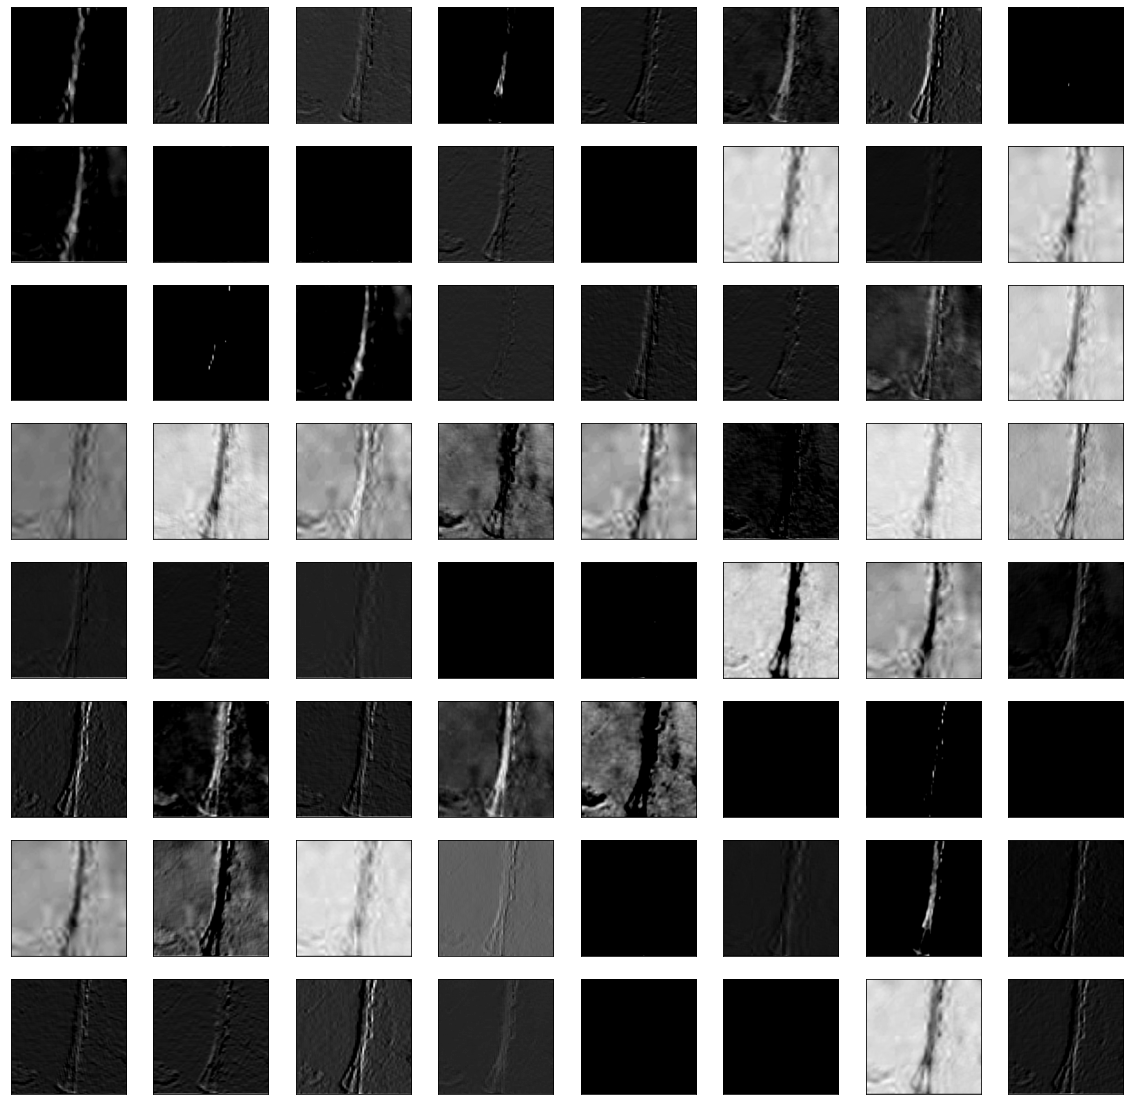

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


<Figure size 1440x720 with 0 Axes>

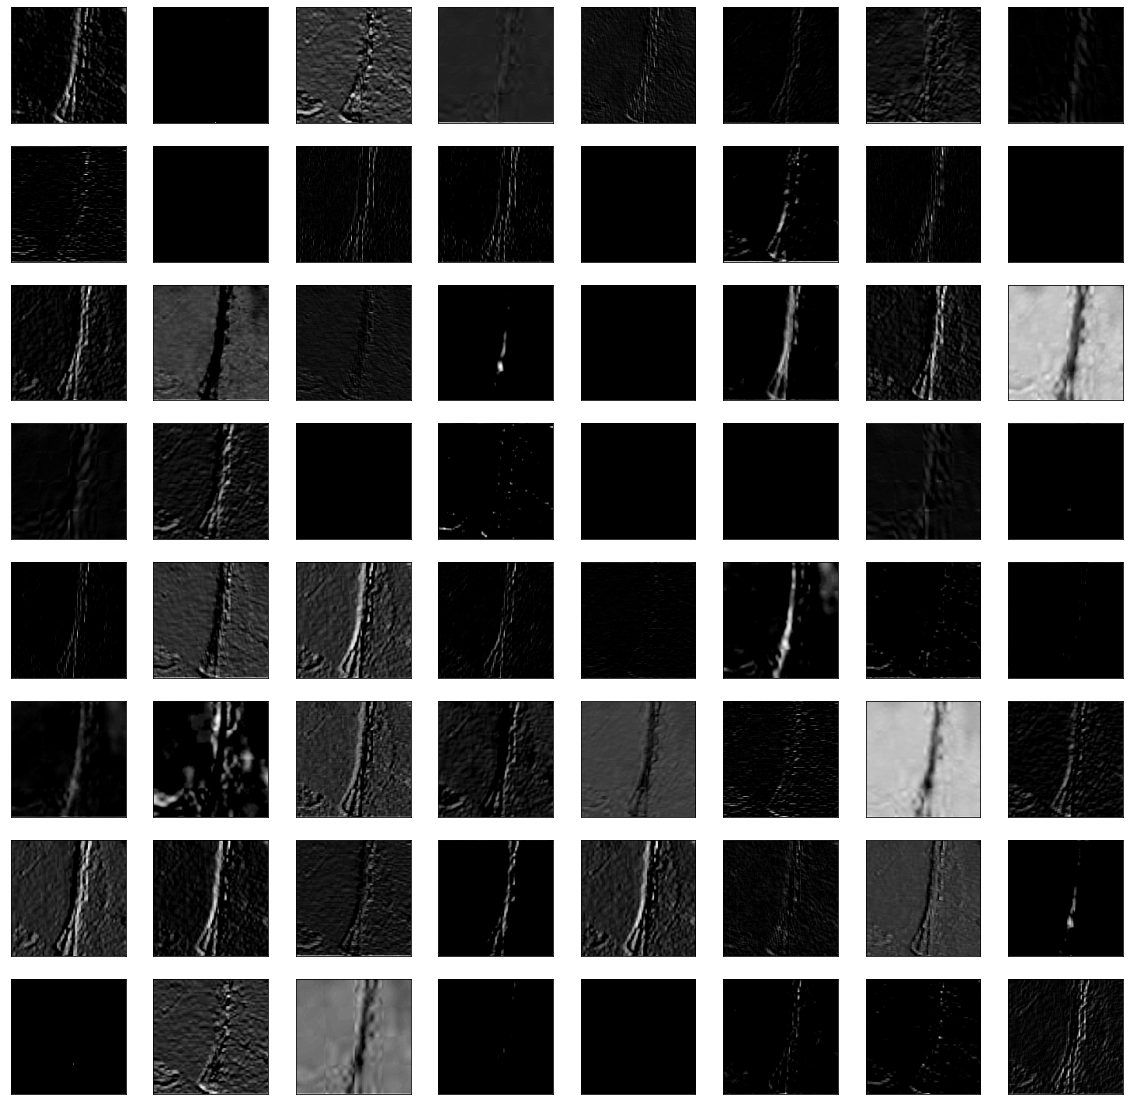

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
)


<Figure size 1440x720 with 0 Axes>

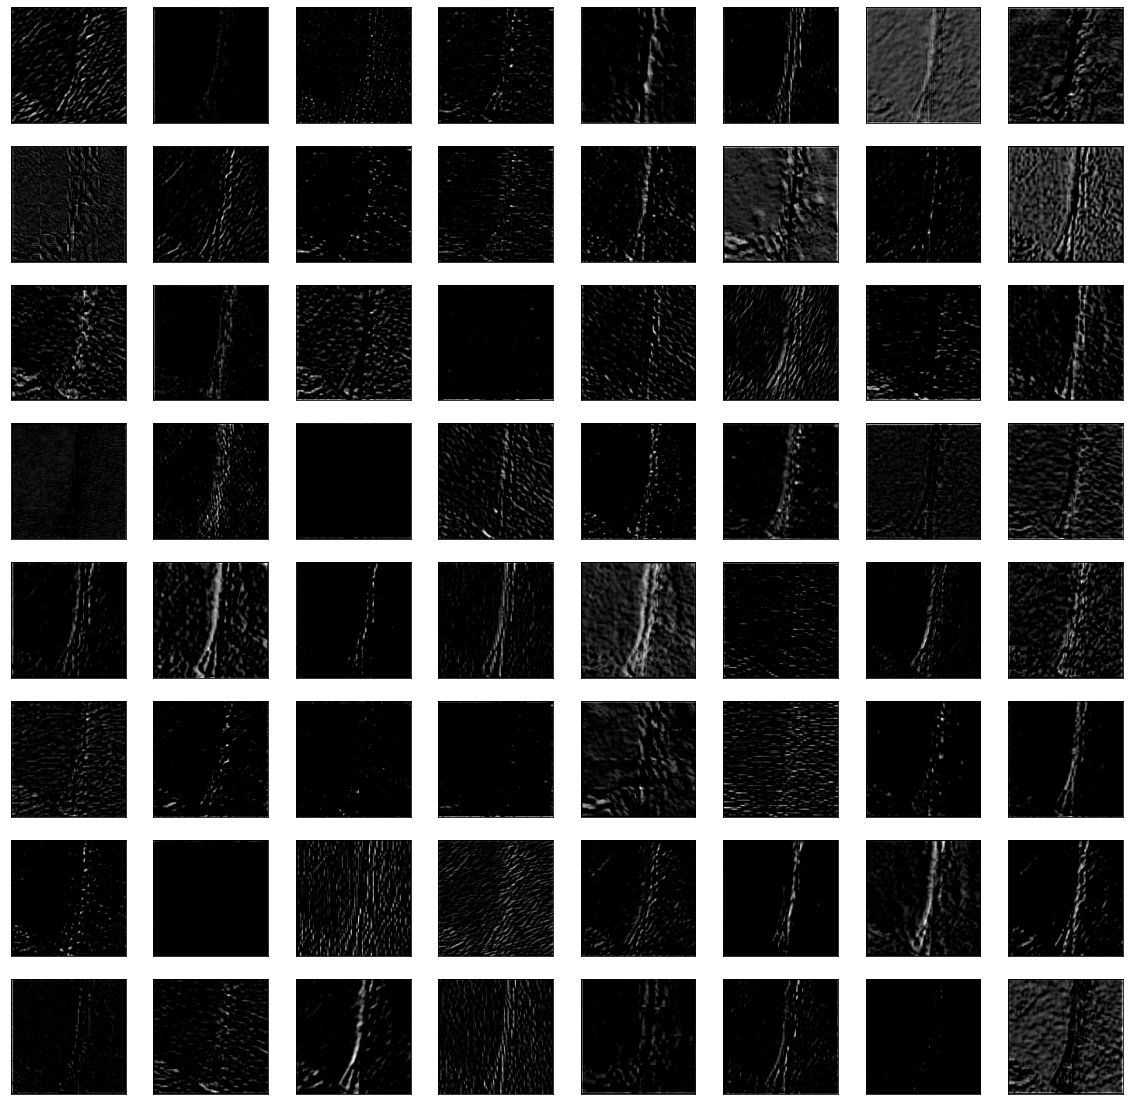

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


<Figure size 1440x720 with 0 Axes>

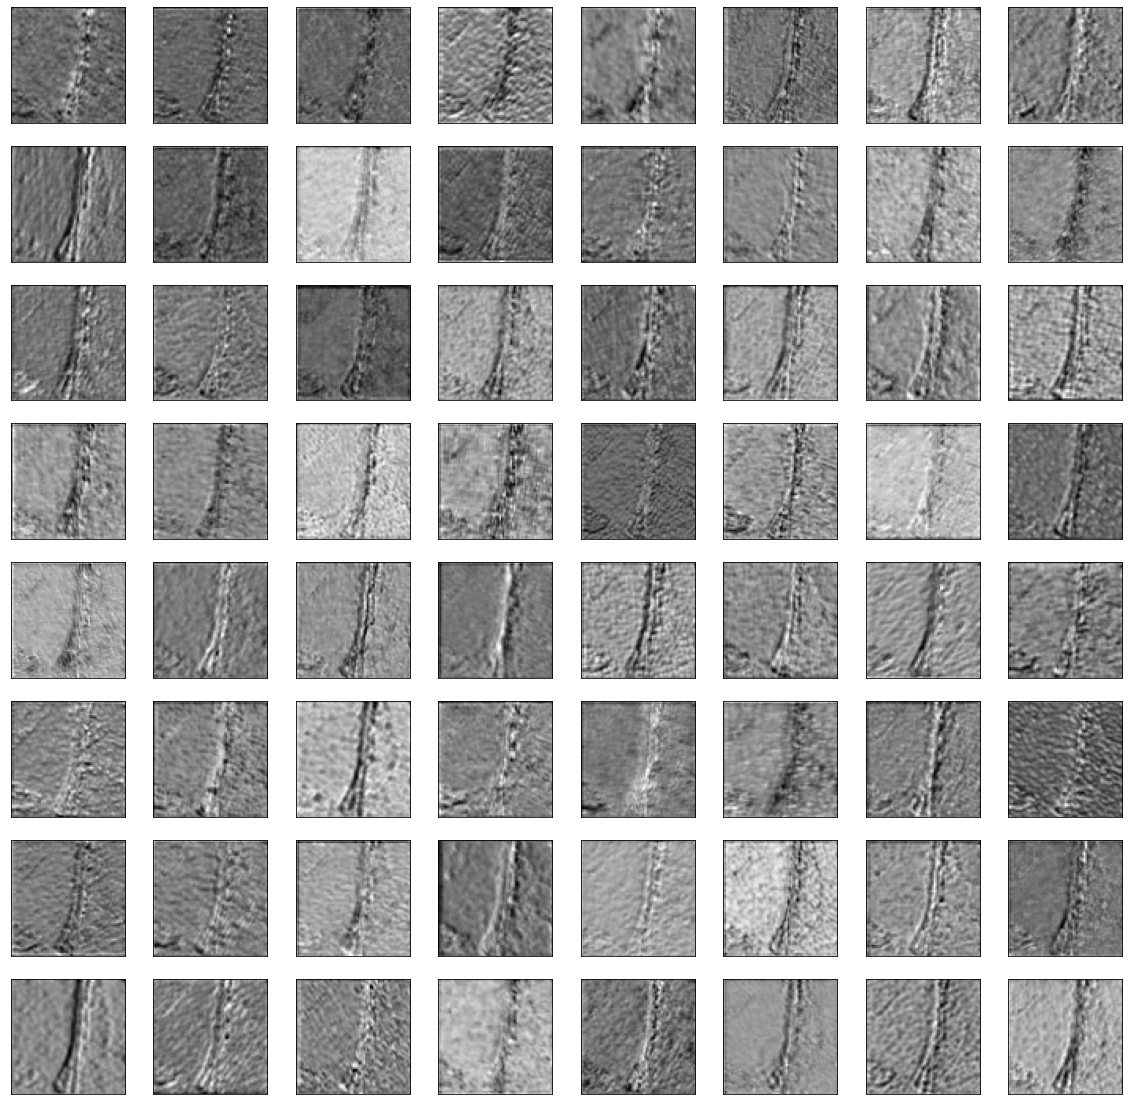

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


<Figure size 1440x720 with 0 Axes>

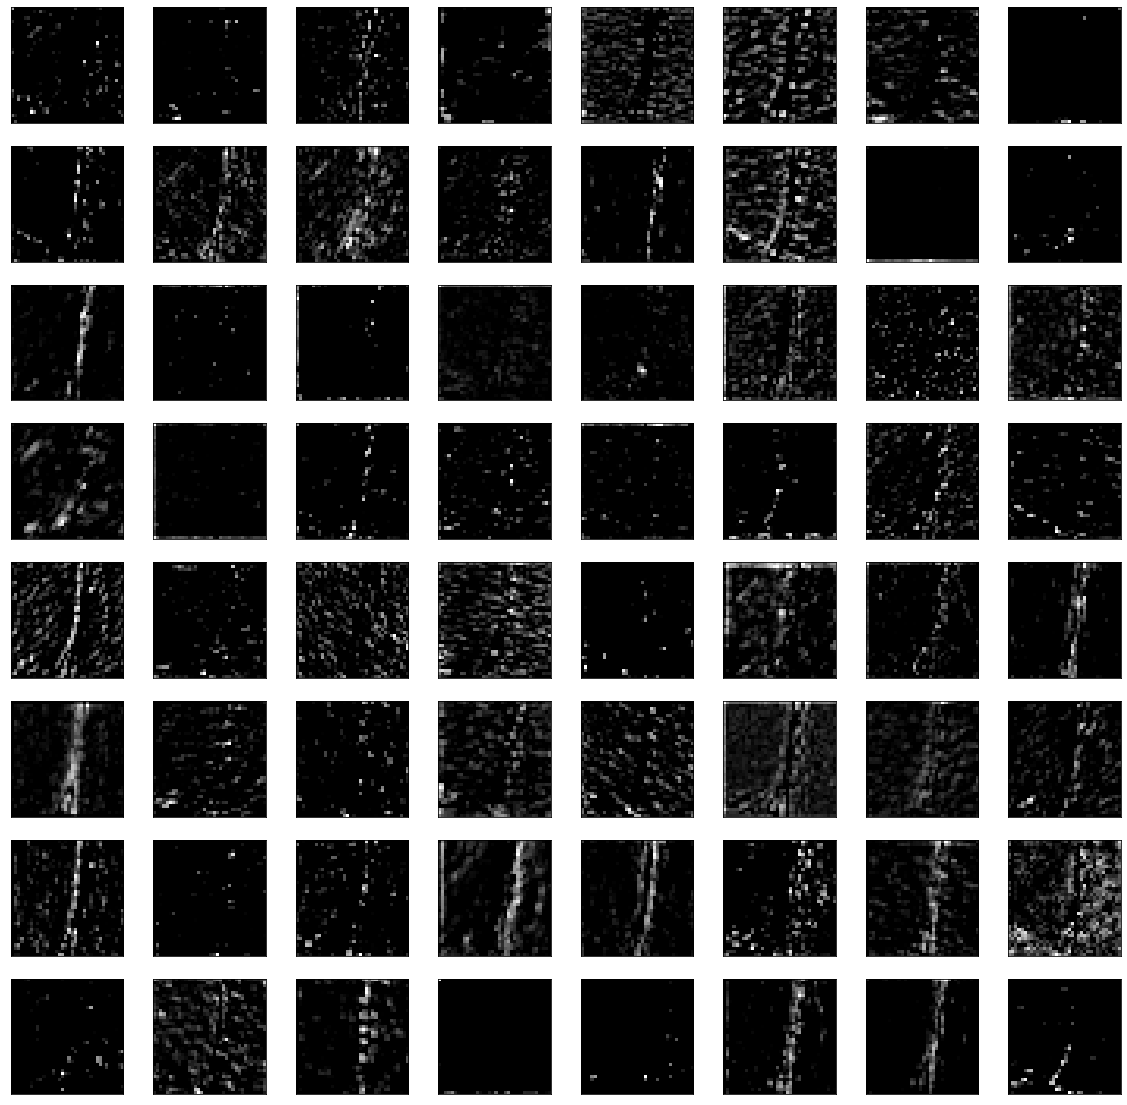

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

<Figure size 1440x720 with 0 Axes>

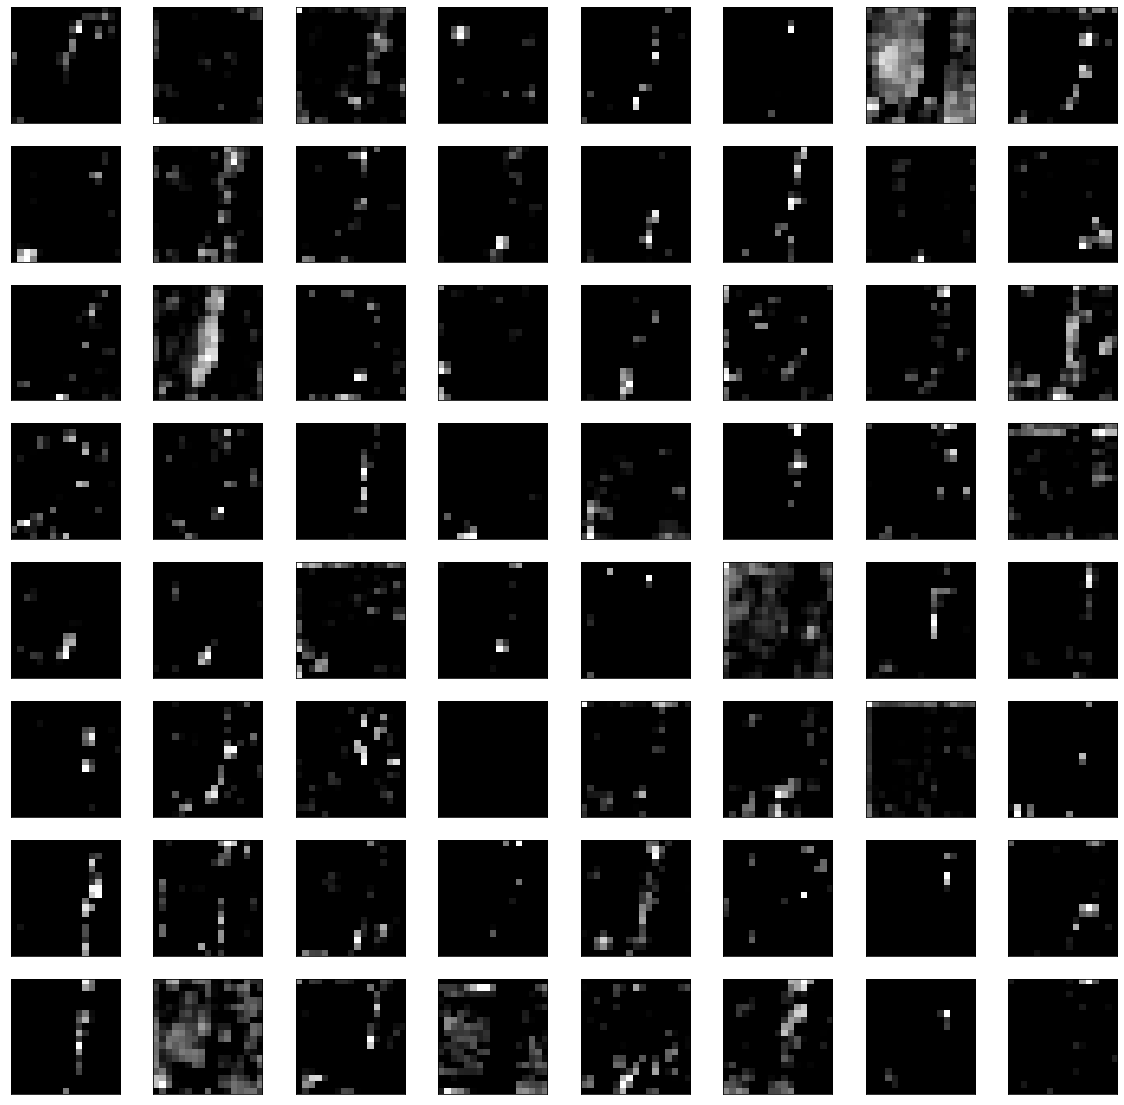

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

<Figure size 1440x720 with 0 Axes>

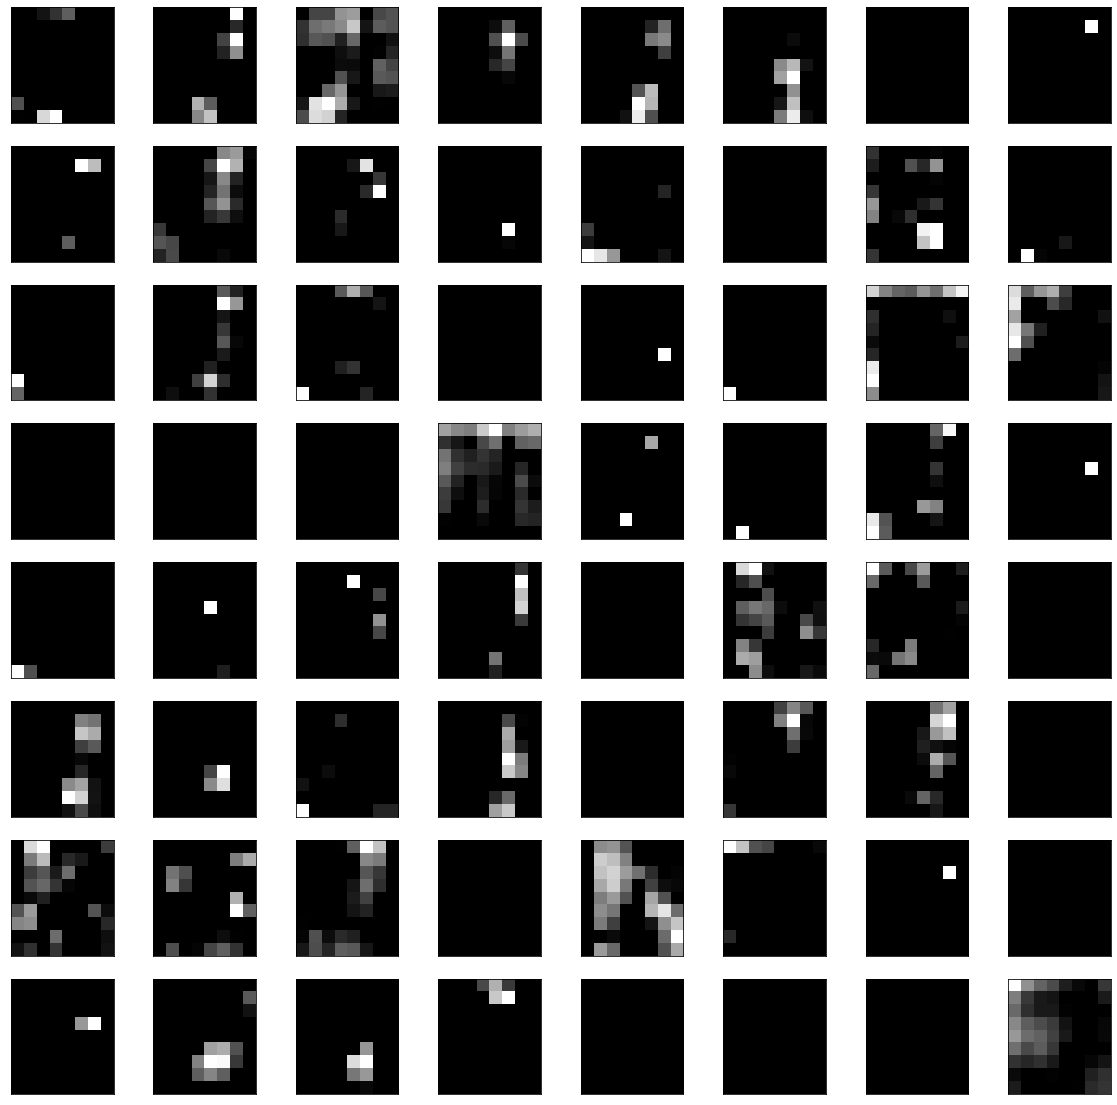

[Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_s

<Figure size 1440x720 with 0 Axes>

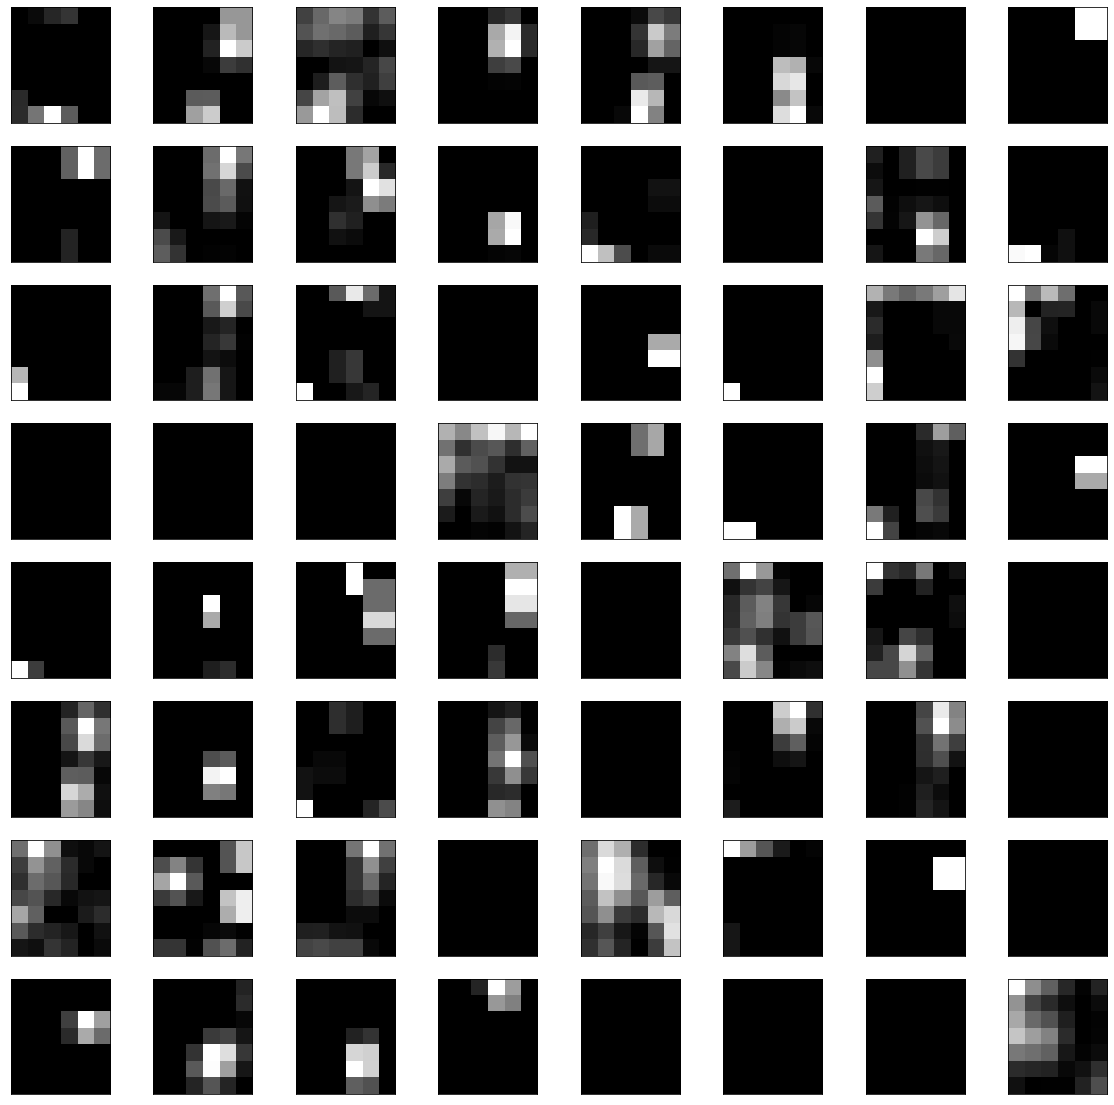

Feature Extraction (minus the classifier layer) done for first image


In [49]:
#plt.figure(figsize = (20,10))


for i, (x,y) in enumerate(aerial_train_loader):
  img_var = Variable(x).cuda()

  img_feat_all,layers,filters = new_model(img_var)


  #print(img_feat_1.shape)

  for j,img_feat_1 in enumerate(img_feat_all):
    plt.figure(figsize = (20,10))


    img_numpy = img_feat_1.cpu().data.numpy()

    print(layers[j])

    # plot all 64 maps in an 8x8 squares
    square = 8
    square1 = int(8)
    ind = 1
    plt.figure(figsize = (20,20))
    for _ in range(square1):
      for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square1, square, ind)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(img_numpy[0, ind-1, :, :-1], cmap='gray')
        ind += 1
    # show the figure
    plt.show()

  print('Feature Extraction (minus the classifier layer) done for first image')
  break

In [18]:
tqdm = partial(tqdm, position=0, leave=True)

# **VGG16 Model Training and Validation**

In [19]:
epochs=10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_vgg,test_loss_vgg,accuracy_vgg = training_and_validation_loop(epochs,step_lr_scheduler,model,optimizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,'vgg16')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0 1.562848687171936
10 0.8532980680465698
20 0.35322946310043335
Done Training
Epoch:  0 Train Loss:  0.8429346442795717 Test Loss:  0.18512837355956435 Accuracy:  93.06930693069307
Saved model with accuracy:  93.06930693069307
0 0.1873331367969513
10 0.02580554410815239
20 0.047210127115249634
Done Training
Epoch:  1 Train Loss:  0.18528383952350572 Test Loss:  0.2575116629401843 Accuracy:  95.04950495049505
Saved model with accuracy:  95.04950495049505
0 0.17666293680667877
10 0.020201733335852623
20 0.185530886054039
Done Training
Epoch:  2 Train Loss:  0.10453654078838344 Test Loss:  0.2417783897059659 Accuracy:  95.04950495049505
0 0.03812095522880554
10 0.20057663321495056
20 0.12721890211105347
Done Training
Epoch:  3 Train Loss:  0.09927637392852026 Test Loss:  0.17437662300653756 Accuracy:  95.04950495049505
0 0.0521421879529953
10 0.0286464411765337
20 0.02009604126214981
Done Training
Epoch:  4 Train Loss:  0.0974644476082176 Test Loss:  0.16087727372845015 Accuracy:  97.029

# **Resnet-50 Model Training and Validation**

In [50]:
gpu_flag = torch.cuda.is_available()

#preloading Resnet18
model = models.resnet50(pretrained = True)

#append a new last layer
model.fc = nn.Linear(2048,num_classes)

# define loss function
criterion = nn.CrossEntropyLoss()

# setup SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer,5,.3)

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
    
print(model)

True
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride

## **Summary of how an example image (224,224,3) is processed through the model-pipleine**

In [21]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [22]:
epochs=10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_resnet,test_loss_resnet,accuracy_resnet = training_and_validation_loop(epochs,step_lr_scheduler,model,optimizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,'resnet50')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0 1.5865631103515625
10 1.4026012420654297
20 0.24139684438705444
Done Training
Epoch:  0 Train Loss:  0.9044700637459755 Test Loss:  0.9265706514318784 Accuracy:  70.29702970297029
Saved model with accuracy:  70.29702970297029
0 0.728845477104187
10 0.13556507229804993
20 0.6039993762969971
Done Training
Epoch:  1 Train Loss:  0.4641397901667425 Test Loss:  0.48482512434323627 Accuracy:  86.13861386138613
Saved model with accuracy:  86.13861386138613
0 0.1928005963563919
10 0.37228062748908997
20 0.28592565655708313
Done Training
Epoch:  2 Train Loss:  0.40839955081733376 Test Loss:  0.2526685843137481 Accuracy:  91.08910891089108
Saved model with accuracy:  91.08910891089108
0 0.11323396116495132
10 0.46861761808395386
20 0.12560990452766418
Done Training
Epoch:  3 Train Loss:  0.4709880407899618 Test Loss:  0.40851516493906576 Accuracy:  91.08910891089108
0 0.5878835916519165
10 0.05155441164970398
20 0.3235367238521576
Done Training
Epoch:  4 Train Loss:  0.2708692201055013 Test Lo

# **Densenet (121) Model Training and Validation**

In [23]:
gpu_flag = torch.cuda.is_available()

#preloading Resnet18
model = models.densenet121(pretrained = True)

#append a new last layer
model.fc = nn.Linear(1024,num_classes)

# define loss function
criterion = nn.CrossEntropyLoss()

# setup SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer,5,.3)

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
    
print(model)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



True
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

## **Summary of how an example image (224,224,3) is processed through the model-pipleine**

In [29]:
#!pip install torch-summary==1.4.4


In [30]:
#from torchsummary import summary
summary(model,(3,224,224) )

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 28

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 28

In [24]:
epochs=10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_densenet,test_loss_densenet,accuracy_densenet = training_and_validation_loop(epochs,step_lr_scheduler,model,optimizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,'densenet121')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0 9.138383865356445
10 0.9650443196296692
20 0.06078092008829117
Done Training
Epoch:  0 Train Loss:  2.2466538224655848 Test Loss:  3.3180753191312156 Accuracy:  55.445544554455445
Saved model with accuracy:  55.445544554455445
0 0.29421496391296387
10 0.4615996181964874
20 0.7444113492965698
Done Training
Epoch:  1 Train Loss:  0.8245844027170768 Test Loss:  1.306866079568863 Accuracy:  83.16831683168317
Saved model with accuracy:  83.16831683168317
0 0.5446934103965759
10 0.42699798941612244
20 0.8005310893058777
Done Training
Epoch:  2 Train Loss:  0.6438356200949504 Test Loss:  1.1363329117496808 Accuracy:  77.22772277227723
0 1.1019139289855957
10 0.17914268374443054
20 0.1420760601758957
Done Training
Epoch:  3 Train Loss:  0.5895436649712232 Test Loss:  0.28949844096011174 Accuracy:  91.08910891089108
Saved model with accuracy:  91.08910891089108
0 0.22750571370124817
10 0.31196632981300354
20 0.028994735330343246
Done Training
Epoch:  4 Train Loss:  0.3227866735452643 Test Los

# **ShuffleNet Model Training and Validation**

In [25]:
gpu_flag = torch.cuda.is_available()

#preloading Resnet18
model = models.shufflenet_v2_x1_0(pretrained = True)
#append a new last layer
model.fc = nn.Linear(1024,num_classes)

# define loss function
criterion = nn.CrossEntropyLoss()

# setup SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer,5,.3)

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
    
print(model)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth



True
ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_ru

## **Summary of how an example image (224,224,3) is processed through the model-pipleine**

In [26]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              ReLU-3         [-1, 24, 112, 112]               0
         MaxPool2d-4           [-1, 24, 56, 56]               0
            Conv2d-5           [-1, 24, 28, 28]             216
       BatchNorm2d-6           [-1, 24, 28, 28]              48
            Conv2d-7           [-1, 58, 28, 28]           1,392
       BatchNorm2d-8           [-1, 58, 28, 28]             116
              ReLU-9           [-1, 58, 28, 28]               0
           Conv2d-10           [-1, 58, 56, 56]           1,392
      BatchNorm2d-11           [-1, 58, 56, 56]             116
             ReLU-12           [-1, 58, 56, 56]               0
           Conv2d-13           [-1, 58, 28, 28]             522
      BatchNorm2d-14           [-1, 58,

In [27]:
epochs=10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_shufflenet,test_loss_shufflenet,accuracy_shufflenet = training_and_validation_loop(epochs,step_lr_scheduler,model,optimizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,'shufflenet')

0 1.6090871095657349


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


10 1.6052305698394775
20 1.6109883785247803
Done Training
Epoch:  0 Train Loss:  1.6053229570388794 Test Loss:  1.8703609704971313 Accuracy:  12.871287128712872
Saved model with accuracy:  12.871287128712872
0 1.5985110998153687
10 1.5939191579818726
20 1.584482192993164
Done Training
Epoch:  1 Train Loss:  1.5943793608592107 Test Loss:  1.8570719559987385 Accuracy:  15.841584158415841
Saved model with accuracy:  15.841584158415841
0 1.5969932079315186
10 1.577415943145752
20 1.5746530294418335
Done Training
Epoch:  2 Train Loss:  1.5820250465319707 Test Loss:  1.8494968016942341 Accuracy:  12.871287128712872
0 1.5703006982803345
10 1.5678825378417969
20 1.5601204633712769
Done Training
Epoch:  3 Train Loss:  1.5708449758016145 Test Loss:  1.8308024605115254 Accuracy:  13.861386138613861
0 1.5614498853683472
10 1.548805832862854
20 1.5916839838027954
Done Training
Epoch:  4 Train Loss:  1.5606456903310924 Test Loss:  1.8245122631390889 Accuracy:  15.841584158415841
0 1.5563945770263672

# **SqueezeNet Model Training and Validation**

In [28]:
gpu_flag = torch.cuda.is_available()

#preloading Resnet18
model = models.squeezenet1_1(pretrained = True)
#append a new last layer
#model.fc = nn.Linear(1024,num_classes)

# Freeze training for all layers
for param in model.features.parameters():
    param.require_grad = False

    
# num_features = model.classifier[6].in_features
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
model.num_classes = num_classes

# define loss function
criterion = nn.CrossEntropyLoss()

# setup SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer,5,.3)

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
    
print(model)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-f364aa15.pth



True
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Max

## **Summary of how an example image (224,224,3) is processed through the model-pipleine**

In [29]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           1,792
              ReLU-2         [-1, 64, 111, 111]               0
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 16, 55, 55]           1,040
              ReLU-5           [-1, 16, 55, 55]               0
            Conv2d-6           [-1, 64, 55, 55]           1,088
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]           9,280
              ReLU-9           [-1, 64, 55, 55]               0
             Fire-10          [-1, 128, 55, 55]               0
           Conv2d-11           [-1, 16, 55, 55]           2,064
             ReLU-12           [-1, 16, 55, 55]               0
           Conv2d-13           [-1, 64, 55, 55]           1,088
             ReLU-14           [-1, 64,

In [30]:
epochs=10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_squeezenet,test_loss_squeezenet,accuracy_squeezenet = training_and_validation_loop(epochs,step_lr_scheduler,model,optimizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,'squeezenet')

0 2.370865821838379


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


10 1.1117057800292969
20 1.5032753944396973
Done Training
Epoch:  0 Train Loss:  1.348187925723883 Test Loss:  1.1427829662958782 Accuracy:  61.386138613861384
Saved model with accuracy:  61.386138613861384
0 1.107326626777649
10 0.8771452903747559
20 1.3786516189575195
Done Training
Epoch:  1 Train Loss:  1.0833288568716783 Test Loss:  0.9319753547509512 Accuracy:  70.29702970297029
Saved model with accuracy:  70.29702970297029
0 1.202566146850586
10 1.6049587726593018
20 1.324761986732483
Done Training
Epoch:  2 Train Loss:  1.0277675848740797 Test Loss:  1.3383516371250153 Accuracy:  44.554455445544555
0 1.2520273923873901
10 0.8197417259216309
20 1.0175464153289795
Done Training
Epoch:  3 Train Loss:  1.0174243851349904 Test Loss:  1.7177240663052846 Accuracy:  60.396039603960396
0 1.5640711784362793
10 0.664365291595459
20 1.0088777542114258
Done Training
Epoch:  4 Train Loss:  1.0759205222129822 Test Loss:  1.1147720714410145 Accuracy:  64.35643564356435
0 0.7130188345909119
10 0

# **Mobilenet-V3 Model Training and Validation**

In [31]:
gpu_flag = torch.cuda.is_available()

#preloading Resnet18
model = models.mobilenet_v3_large(pretrained = True)
#append a new last layer


# Freeze training for all layers
for param in model.features.parameters():
    param.require_grad = False

model.classifier[3] = nn.Linear(1280,num_classes)    
# num_features = model.classifier[6].in_features
#model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
#model.num_classes = num_classes

# define loss function
criterion = nn.CrossEntropyLoss()

# setup SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer,5,.3)

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
    
print(model)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth



True
MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), s

## **Summary of how an example image (224,224,3) is processed through the model-pipleine**

In [32]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
          Identity-9         [-1, 16, 112, 112]               0
 InvertedResidual-10         [-1, 16, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]           1,024
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
           Conv2d-14           [-1, 64,

In [33]:
epochs=10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_mobilenetv3,test_loss_mobilenetv3,accuracy_mobilenetv3 = training_and_validation_loop(epochs,step_lr_scheduler,model,optimizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,'mobilenetv3')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0 1.7044938802719116
10 0.8560001850128174
20 0.6709185838699341
Done Training
Epoch:  0 Train Loss:  0.9067165920367608 Test Loss:  0.6518133531014124 Accuracy:  87.12871287128714
Saved model with accuracy:  87.12871287128714
0 0.23527871072292328
10 0.120726577937603
20 0.13641296327114105
Done Training
Epoch:  1 Train Loss:  0.19453917006747082 Test Loss:  0.3477473681171735 Accuracy:  91.08910891089108
Saved model with accuracy:  91.08910891089108
0 0.08034613728523254
10 0.11464028060436249
20 0.0319516621530056
Done Training
Epoch:  2 Train Loss:  0.09244648238214162 Test Loss:  0.9670339624087015 Accuracy:  64.35643564356435
0 0.02152995392680168
10 0.06685855239629745
20 0.14557349681854248
Done Training
Epoch:  3 Train Loss:  0.06261978070968045 Test Loss:  1.0001689592997234 Accuracy:  65.34653465346534
0 0.05367603525519371
10 0.013469028286635876
20 0.010422355495393276
Done Training
Epoch:  4 Train Loss:  0.036673401339122884 Test Loss:  0.615285669763883 Accuracy:  81.188

# **Resnext50 Model Training and Validation**

In [34]:
gpu_flag = torch.cuda.is_available()

#preloading Resnet18
model = models.resnext50_32x4d(pretrained = True)
#append a new last layer


# Freeze training for all layers
#for param in model.features.parameters():
#    param.require_grad = False

model.fc = nn.Linear(2048,num_classes)    
# num_features = model.classifier[6].in_features
#model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
#model.num_classes = num_classes

# define loss function
criterion = nn.CrossEntropyLoss()

# setup SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer,5,.3)

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
    
print(model)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth



True
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_s

## **Summary of how an example image (224,224,3) is processed through the model-pipleine**

In [35]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [36]:
epochs=10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_resnext50,test_loss_resnext50,accuracy_resnext50 = training_and_validation_loop(epochs,step_lr_scheduler,model,optimizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,'resnext50')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0 1.602941870689392
10 1.0839041471481323
20 0.28791990876197815
Done Training
Epoch:  0 Train Loss:  0.9075254436868888 Test Loss:  0.5383091866970062 Accuracy:  83.16831683168317
Saved model with accuracy:  83.16831683168317
0 0.042323045432567596
10 0.6951889991760254
20 1.3334811925888062
Done Training
Epoch:  1 Train Loss:  0.3572772375236337 Test Loss:  0.7578728844722112 Accuracy:  81.18811881188118
0 0.2989128828048706
10 0.21760797500610352
20 0.6661592721939087
Done Training
Epoch:  2 Train Loss:  0.4727291588922246 Test Loss:  1.5387743314107258 Accuracy:  76.23762376237623
0 0.7490621209144592
10 0.09535327553749084
20 0.5054001212120056
Done Training
Epoch:  3 Train Loss:  0.491560452671435 Test Loss:  0.385557191252398 Accuracy:  91.08910891089108
Saved model with accuracy:  91.08910891089108
0 0.03432445973157883
10 0.3373035788536072
20 0.01228652335703373
Done Training
Epoch:  4 Train Loss:  0.23032332039796388 Test Loss:  0.3899754925320546 Accuracy:  91.0891089108910

In [37]:
#Pre processing the data
normalize = transforms.Normalize(mean = [0.485,0.456,0.406],
                                std = [0.229,0.224,0.225])
resize = transforms.Resize((299,299))



preprocessor = transforms.Compose([ resize, transforms.ToTensor(), normalize
                                   ])

aerial_dataset_full = get_sat_data(aerial_path,preprocessor)

# Creating data indices for training and validation splits:
dataset_size = len(aerial_dataset_full)
indices = list(range(dataset_size))
validation_split = 0.2
split = int(np.floor(validation_split * dataset_size))
shuffle_dataset = True
random_seed= 101

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

aerial_train_loader = torch.utils.data.DataLoader(aerial_dataset_full, batch_size=16, 
                                           sampler=train_sampler)
aerial_validation_loader = torch.utils.data.DataLoader(aerial_dataset_full, batch_size=16,
                                                sampler=valid_sampler)



gpu_flag = torch.cuda.is_available()

#preloading Resnet18
model = models.inception_v3(pretrained = True)
#append a new last layer


# Freeze training for all layers
#for param in model.features.parameters():
#    param.require_grad = False

model.fc = nn.Linear(2048,num_classes)    
# num_features = model.classifier[6].in_features
#model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
#model.num_classes = num_classes
model.aux_logits=False

# define loss function
criterion = nn.CrossEntropyLoss()

# setup SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer,5,.3)

gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    model = model.cuda()
    
print(model)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



True
Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3)

## **Summary of how an example image (299,299,3) is processed through the model-pipleine**

In [38]:
summary(model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [39]:
epochs=10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_inceptionv3,test_loss_inceptionv3,accuracy_inceptionv3= training_and_validation_loop(epochs,step_lr_scheduler,model,optimizer,aerial_train_loader,aerial_validation_loader,best_acc,best_model_wts,'inceptionv3')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0 1.5312782526016235
10 1.0991261005401611
20 0.4819774627685547
Done Training
Epoch:  0 Train Loss:  1.09126678109169 Test Loss:  0.4952628513177236 Accuracy:  88.11881188118812
Saved model with accuracy:  88.11881188118812
0 0.5206536650657654
10 0.5972175002098083
20 0.20286329090595245
Done Training
Epoch:  1 Train Loss:  0.43909166810604244 Test Loss:  0.5022932936747869 Accuracy:  83.16831683168317
0 0.029663583263754845
10 0.2688331604003906
20 0.7232166528701782
Done Training
Epoch:  2 Train Loss:  0.35298985393288046 Test Loss:  0.35934006919463474 Accuracy:  92.07920792079207
Saved model with accuracy:  92.07920792079207
0 0.043572623282670975
10 0.7370339035987854
20 0.1756567656993866
Done Training
Epoch:  3 Train Loss:  0.26234725762445193 Test Loss:  0.2054745890200138 Accuracy:  94.05940594059406
Saved model with accuracy:  94.05940594059406
0 1.0982884168624878
10 0.01348782517015934
20 0.05854685232043266
Done Training
Epoch:  4 Train Loss:  0.1312421516228754 Test Los

# **Accuracy Plot vs Epochs for All Models**

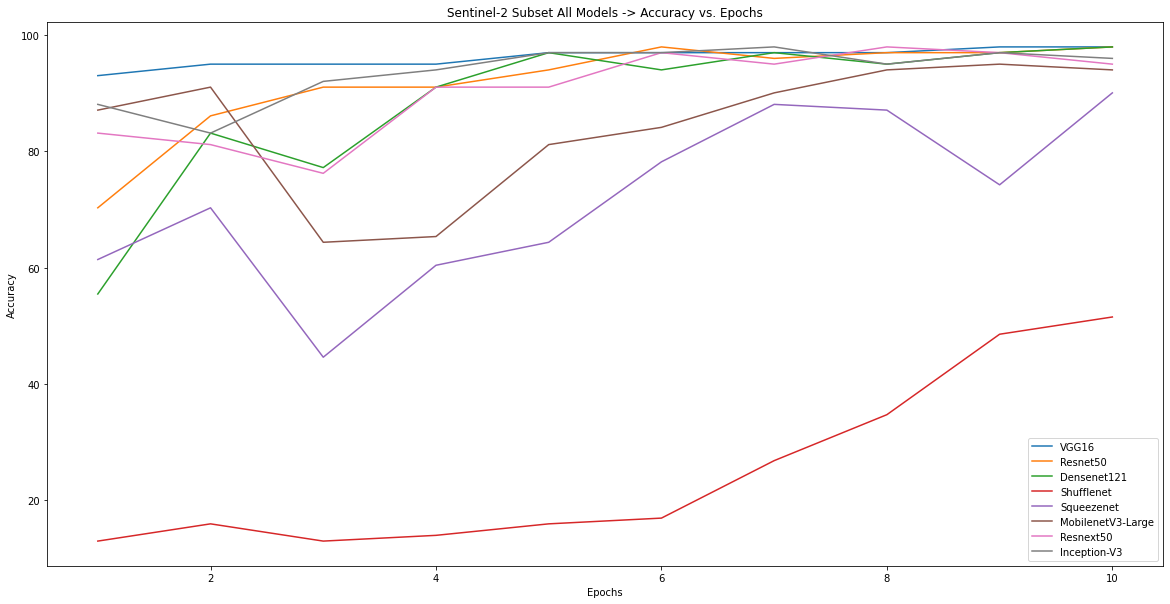

In [40]:
list_epochs = [i+1 for i in range(10)]

plt.figure(figsize = (20,10))


plt.plot(list_epochs,accuracy_vgg,label='VGG16')
plt.plot(list_epochs,accuracy_resnet,label='Resnet50')
plt.plot(list_epochs,accuracy_densenet,label='Densenet121')
plt.plot(list_epochs,accuracy_shufflenet,label='Shufflenet')
plt.plot(list_epochs,accuracy_squeezenet,label='Squeezenet')
plt.plot(list_epochs,accuracy_mobilenetv3,label='MobilenetV3-Large')
plt.plot(list_epochs,accuracy_resnext50,label='Resnext50')
plt.plot(list_epochs,accuracy_inceptionv3,label='Inception-V3')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Sentinel-2 Subset All Models -> Accuracy vs. Epochs')
plt.legend()



# **Training Loss Plot vs Epochs for All Models**

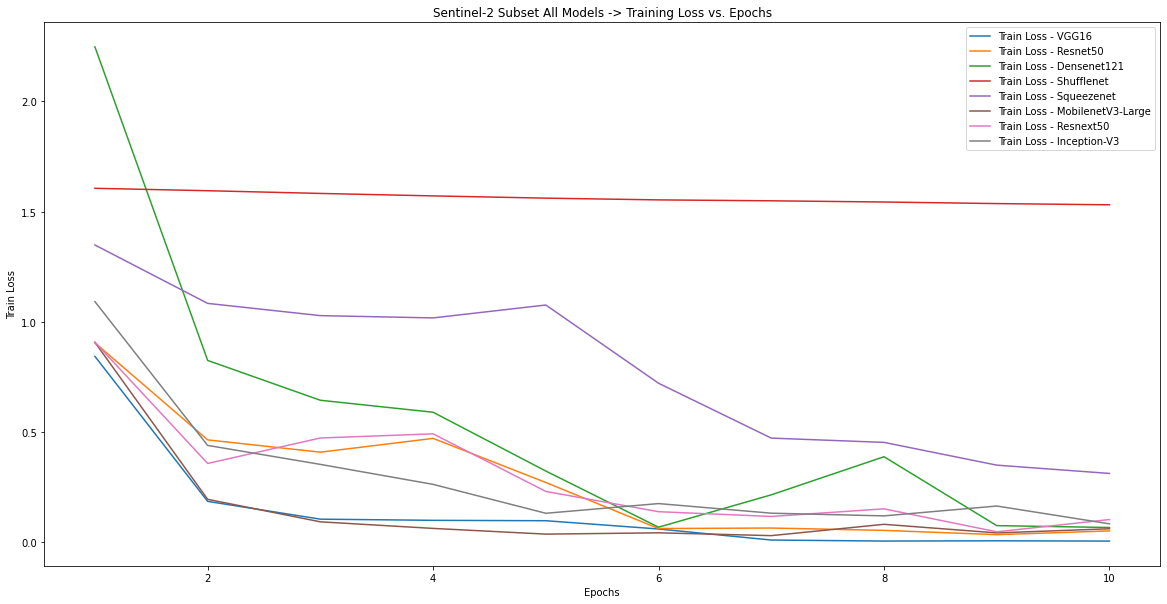

In [41]:
plt.figure(figsize = (20,10))


plt.plot(list_epochs,train_loss_vgg,label='Train Loss - VGG16')
plt.plot(list_epochs,train_loss_resnet,label='Train Loss - Resnet50')
plt.plot(list_epochs,train_loss_densenet,label='Train Loss - Densenet121')
plt.plot(list_epochs,train_loss_shufflenet,label='Train Loss - Shufflenet')
plt.plot(list_epochs,train_loss_squeezenet,label='Train Loss - Squeezenet')
plt.plot(list_epochs,train_loss_mobilenetv3,label='Train Loss - MobilenetV3-Large')
plt.plot(list_epochs,train_loss_resnext50,label='Train Loss - Resnext50')
plt.plot(list_epochs,train_loss_inceptionv3,label='Train Loss - Inception-V3')


plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Sentinel-2 Subset All Models -> Training Loss vs. Epochs')
plt.legend()


# **Test Loss Plot vs Epochs for All Models**

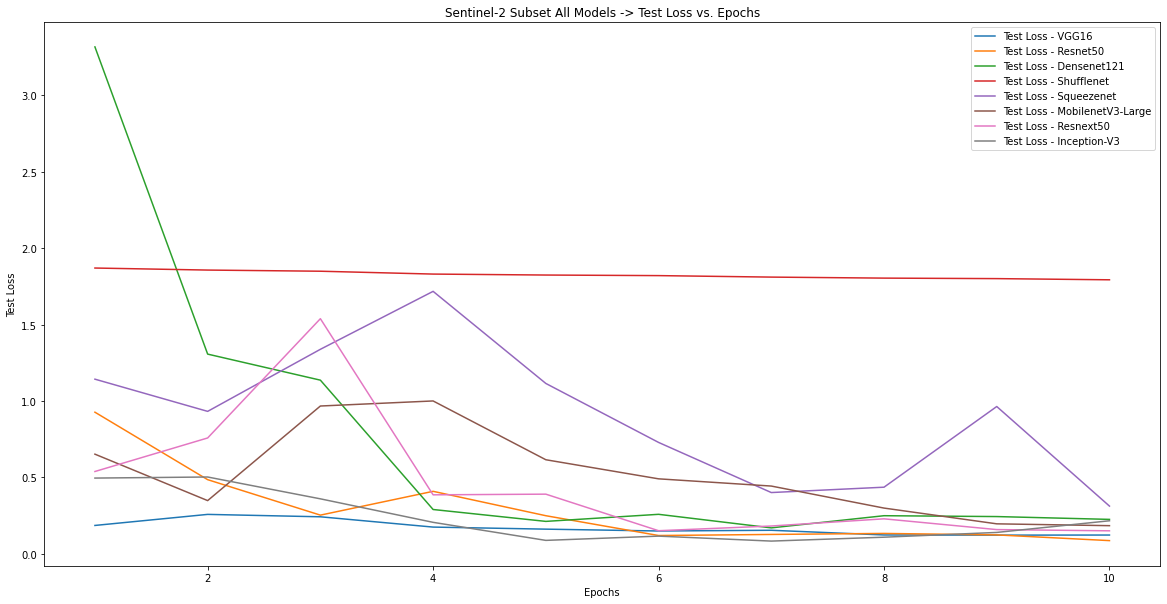

In [42]:
plt.figure(figsize = (20,10))


plt.plot(list_epochs,test_loss_vgg,label='Test Loss - VGG16')
plt.plot(list_epochs,test_loss_resnet,label='Test Loss - Resnet50')
plt.plot(list_epochs,test_loss_densenet,label='Test Loss - Densenet121')
plt.plot(list_epochs,test_loss_shufflenet,label='Test Loss - Shufflenet')
plt.plot(list_epochs,test_loss_squeezenet,label='Test Loss - Squeezenet')
plt.plot(list_epochs,test_loss_mobilenetv3,label='Test Loss - MobilenetV3-Large')
plt.plot(list_epochs,test_loss_resnext50,label='Test Loss - Resnext50')
plt.plot(list_epochs,test_loss_inceptionv3,label='Test Loss - Inception-V3')


plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('Sentinel-2 Subset All Models -> Test Loss vs. Epochs')

plt.legend()


In [43]:
#!curl -k https://files.inria.fr/aerialimagelabeling/getAerial.sh | bash



In [51]:
#!ls 

In [52]:
#import shutil
#shutil.copytree('sample_data/','/content/drive/My Drive/AerialImageDataset_sample_data/')

## **Reference**

https://pytorch.org/vision/stable/models.html